# Recording on Preston

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from scipy.signal import spectrogram
from sklearn.model_selection import train_test_split

In [2]:
eeg_df = pd.read_csv("../data/2018-10-12-preston_walk_raw.csv", skiprows=15)

In [3]:
eeg_df.head()

,Time,LE,F4,C4,PO8,PO7,C3,F3,Trigger,Time_Offset,ADC_Status,ADC_Sequence,Event,Comments
0,0.0033,3642.0,-2536.8,3530.1,2459.4,296.7,3454.5,-1103.4,0,6,0,207,0,Start Data Acquisition
1,0.0067,3635.7,-2526.3,3531.0,2451.9,299.7,3459.6,-1098.9,0,12,0,208,0,NaN
2,0.0100,3632.7,-2535.9,3528.6,2441.4,302.1,3454.8,-1103.4,0,18,0,209,0,NaN
3,0.0133,3626.7,-2535.3,3524.1,2450.1,297.9,3455.1,-1097.1,0,24,0,210,0,NaN
4,0.0167,3626.4,-2527.8,3539.4,2469.0,289.8,3452.7,-1089.9,0,30,0,211,0,NaN


## Filter data

In [4]:
from mne.filter import filter_data

In [5]:
channels = eeg_df.columns[1:8] 

In [6]:
eeg_data = eeg_df[channels].values

In [7]:
filtered = filter_data(eeg_data.T, sfreq=300, l_freq=1, h_freq=40)

Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 991 samples (3.303 sec) selected


In [8]:
eeg_df[channels] = filtered.T

## Epoch data

In [9]:
events = eeg_df.Event.nonzero()[0]

In [10]:
events

array([  1446,   2970,   7952,  47145,  78073, 135086], dtype=int64)

In [11]:
walk_one_start = events[2] + 300
walk_one_stop = events[3] - 300
typing_start = events[3] + 300
typing_stop = events[4] - 300
talking_start = events[4] + 300  
talking_stop = events[5] - 300  
walk_two_start = events[5] + 300
walk_two_stop = len(eeg_df) - 9000

In [12]:
typing_data = eeg_df.loc[typing_start : typing_stop][channels]
talking_data = eeg_df.loc[talking_start : talking_stop][channels]
walk_one_data = eeg_df.loc[walk_one_start : walk_one_stop][channels]
walk_two_data = eeg_df.loc[walk_two_start : walk_two_stop][channels]

In [13]:
typing_data = typing_data[: len(typing_data) // 300 * 300]
talking_data = talking_data[: len(talking_data) // 300 * 300]
walk_one_data = walk_one_data[: len(walk_one_data) // 300 * 300]
walk_two_data = walk_two_data[: len(walk_two_data) // 300 * 300]
walk_data = np.concatenate((walk_one_data, walk_two_data), axis=0)

## Check the data

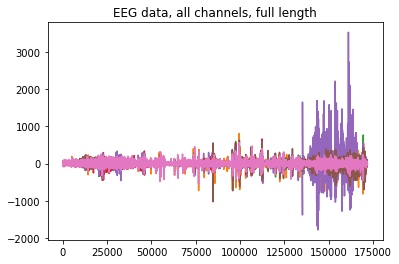

In [14]:
plt.figure()
plt.plot(eeg_df[channels])
plt.title('EEG data, all channels, full length')
plt.show()

In [15]:
print('max(walk_one_data): ' + str(np.max(np.max(walk_one_data[channels]))))
print('max(typing_data): ' + str(np.max(np.max(typing_data[channels]))))
print('max(talking_data): ' + str(np.max(np.max(talking_data[channels]))))
print('max(walk_two_data): ' + str(np.max(np.max(walk_two_data[channels]))))

max(walk_one_data): 339.4654536353107
max(typing_data): 452.6927721609819
max(talking_data): 806.7519828079727
max(walk_two_data): 3523.6671266897297


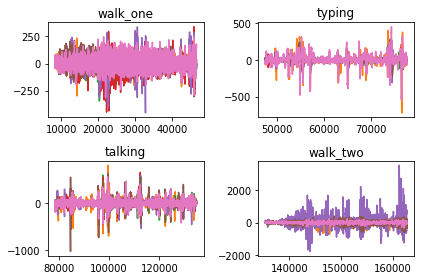

In [16]:
plt.figure()

plt.subplot(221)
plt.plot(walk_one_data[channels])
plt.title('walk_one')

plt.subplot(222)
plt.plot(typing_data[channels])
plt.title('typing')

plt.subplot(223)
plt.plot(talking_data[channels])
plt.title('talking')

plt.subplot(224)
plt.plot(walk_two_data[channels])
plt.title('walk_two')

plt.tight_layout()
plt.show()

## Normalize the data
Normalize the data for each channel (for each epoch) such that it has mean zero and unit variance

In [17]:
walk_one_normalized = (walk_one_data[channels] - np.mean(walk_one_data[channels]))/np.std(walk_one_data[channels])
typing_normalized = (typing_data[channels] - np.mean(typing_data[channels]))/np.std(typing_data[channels])
talking_normalized = (talking_data[channels] - np.mean(talking_data[channels]))/np.std(talking_data[channels])
walk_two_normalized = (walk_two_data[channels] - np.mean(walk_two_data[channels]))/np.std(walk_two_data[channels])
walk_normalized = np.concatenate((walk_one_normalized, walk_two_normalized), axis=0)

In [18]:
talking_normalized.head()

,LE,F4,C4,PO8,PO7,C3,F3
78373,-0.206989,0.335267,-0.190874,0.009713,0.396477,-0.068953,0.632316
78374,-0.206763,0.396441,-0.143328,0.054009,0.416498,-0.046811,0.619989
78375,-0.163812,0.412703,-0.075891,0.077756,0.421192,-0.001687,0.618062
78376,-0.106164,0.387837,-0.024093,0.078757,0.404805,0.043561,0.624240
78377,-0.063923,0.350168,-0.009138,0.064185,0.376427,0.069384,0.637449


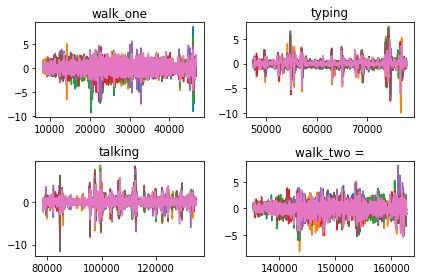

In [19]:
plt.figure()

plt.subplot(221)
plt.plot(walk_one_normalized[channels])
plt.title('walk_one')

plt.subplot(222)
plt.plot(typing_normalized[channels])
plt.title('typing')

plt.subplot(223)
plt.plot(talking_normalized[channels])
plt.title('talking')

plt.subplot(224)
plt.plot(walk_two_normalized[channels])
plt.title('walk_two =')

plt.tight_layout()
plt.show()

## Power, create data

In [20]:
other_data = np.concatenate((typing_normalized, talking_normalized), axis=0) 

In [21]:
f, t, spec = spectrogram(walk_normalized.T, fs=300, nperseg=600, noverlap=300)

In [22]:
np.shape(spec)

(7, 301, 218)

In [23]:
walk_spec = spec[:, :81, :].reshape(-1, 218).T

In [24]:
f, t, spec = spectrogram(other_data.T, fs=300, nperseg=600, noverlap=300)

In [25]:
other_spec = spec[:, :81, :].reshape(-1, 288).T

In [26]:
X = np.concatenate((walk_spec, other_spec), axis=0)

In [27]:
y = np.concatenate((np.ones(len(walk_spec)), np.zeros(len(other_spec))), axis=0)

In [28]:
# shuffle data to get train/test
args = np.arange(len(X))
np.random.shuffle(args)
X = X[args]
y = y[args]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## SVM, Hyperparameter tuning (Walking vs. others)

In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [31]:
Cs = [0.001, 0.01, 0.1, 1, 5, 10]
degrees = [1, 5, 10, 15, 20, 50, 100, 500]

In [32]:
hyper_params = {"C":Cs, "degree":degrees}

In [33]:
grid = GridSearchCV(SVC(kernel='poly'), param_grid=hyper_params, cv=KFold(n_splits=5), verbose=True)

In [34]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. S

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this war

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this war

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this war

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this war

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this war

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this war

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this war

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this war

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this war

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 10], 'degree': [1, 5, 10, 15, 20, 50, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [35]:
grid.best_estimator_

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [36]:
svc = SVC(kernel='poly', C=10, degree=1)
svc.fit(X_train, y_train)

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [37]:
svc.score(X_train, y_train)

0.8703296703296703

In [38]:
svc.score(X_test, y_test)

0.8431372549019608

### confusion matrix: 
| type | type |
|--------------|--------------|
|True Positive | False Positive|
|False Negative| True Negative|

In [39]:
from sklearn.metrics import confusion_matrix

In [40]:
confusion_matrix(y_test, svc.predict(X_test))

array([[31,  1],
       [ 7, 12]], dtype=int64)